### Neural network model to distinguish cat vs non cat
This is the first model created after learning nuts/ bolts present in NN by Ram Sundaravel.

this model needs further tunning on gradient descent.

#### History Log
1. Initial completion - 19 July 2018

### import library

In [418]:
# import libary
import h5py
import numpy as np
from matplotlib import pyplot as plt

### Helper function to load dataset from hdf5 file

In [419]:
def load_data_set(train_file, test_file):  
    train = h5py.File(train_file,"r")
    test = h5py.File(test_file,"r")

    # explore hdf5 dataset
#     print("keys in h5py file")
#     for key in train.keys():
#         print("   ",key)

    # creation of train test matrix from h5py file
    traininig_x = np.array(train['train_set_x'])
    training_y = np.array(train['train_set_y'])
    train_classes = np.array(train['list_classes'])

    test_x = np.array(test['test_set_x'])
    test_y = np.array(test['test_set_y'],ndmin=1)
    test_classes = np.array(test['list_classes'])

    #printing information about train and test sets
    # print('Training set X : ', traininig_x.shape)
    # print('Training set Y : ', training_y.shape)
    # print('Test set X : ', test_x.shape)
    # print('Test set Y : ', test_y.shape)
    print("Data set load Successful~~~")
    print('Number of samples in training data : ' + str(Y.shape[1]))
    return traininig_x,training_y,test_x,test_y,train_classes 

### Initialize parameters 
initialize paramaters w and b for each layer

In [420]:
def initialize_parameters(layers_dim):
    np.random.seed(3)
    parameters = {}
    for l in range(1,len(layers_dim)):
        parameters['W'+str(l)] = np.random.randn(layers_dim[l],layers_dim[l-1]) /np.sqrt(layers_dim[l-1]) #*.01
        parameters['b'+str(l)] = np.zeros((layers_dim[l],1))
        assert(parameters['W'+str(l)].shape) == (layers_dim[l],layers_dim[l-1])
        # make sure dimension of w is (number of neurons current, previous_layer_neurons)
        assert(parameters['b'+str(l)].shape) == (layers_dim[l],1)
    return parameters

### Derive forward linear function 

In [421]:
def linear_forward(W,b,A_Prev):
    Z = np.dot(W,A_Prev) + b
    cache = (W,b,A_Prev)
    # print(Z.shape)
    return Z, cache

### Forward Activation function

In [422]:
def linear_forward_activation(W,b,A_prev,activation):
    Z,linear_function_cache = linear_forward(W,b,A_prev)
    
    if activation == 'sigmoid':
        A = 1/(1+np.exp(-Z))
    
    if activation == 'relu':
        A = np.maximum(0,Z) # Z * (Z>0)
    
    cache = linear_function_cache, Z
    return A, cache

### Forward propogation

In [423]:
def model_forward_propogation(X,layers_dim,parameters):
    number_of_layers = int(len(parameters)/2)
    A = X
    caches = {}


    for layer in range(1, number_of_layers):
        A_prev = A
        A,cache = linear_forward_activation(W=parameters['W'+str(layer)],
                                             b = parameters['b'+str(layer)],
                                             A_prev=A_prev,
                                             activation='relu')
        caches['layer'+ str(layer)] = cache
        
    AL,cache = linear_forward_activation(W=parameters['W'+str(number_of_layers)],
                                         b = parameters['b'+str(number_of_layers)],
                                         A_prev=A, # fixed code to pass final - 1 output to final layer
                                         activation='sigmoid')
    # caches.append(cache)
    caches['layer'+ str(number_of_layers)] = cache

    assert(AL.shape == (1,X.shape[1]))
    return AL, caches

### Compute cost

In [424]:
def compute_cost(AL,Y):
    m = Y.shape[1] # number of samples
    # compute cost
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    
    assert np.squeeze(cost).shape == () # assert cost is just single decimal value
    return cost

## Helper functions for doing back propogation
### Sigmoid and Relu backprop derivative

In [425]:
def sigmoid_bacward_derivation(dA,activation_cache):
    Z = activation_cache
    A = 1 / (1 + np.exp(-Z))
    dZ = dA * A * (1 - A)
    assert (dZ.shape == dA.shape)
    return dZ

def relu_backward_derivation(dA,activation_cache):
    Z = activation_cache
    # print('Z shape ' , Z.shape)
    # print('dA shape ' , dA.shape)
    dZ = np.array(dA,copy=True)  # just copy dA to dZ
    dZ[Z<=0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

### Backward linear activation
This function takes dA and returns dW, db, dA_prev

In [426]:
def backward_linear_activation(dA,cache, activation):
    linear_activation,activation_cache = cache
    W,b,A_prev = linear_activation
    m = A_prev.shape[1]
    
    # find dZ
    if activation =='sigmoid':
        dZ = sigmoid_bacward_derivation(dA,activation_cache)
    
    if activation == 'relu':
        dZ = relu_backward_derivation(dA,activation_cache)
    
    # find dW,db,dA_prev
    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert(dA_prev.shape == A_prev.shape)
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    
    return dA_prev,dW, db  

### model backprop for Layer L to 1

In [427]:
def model_backward_propogation(AL,Y,caches):
    L = len(caches)  # number of layers
    m = AL.shape[1] # number of samples
    grads = {}
    
    # find derivative of loss with repect to output layer (dAL)  
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # find dA_prev, dW, db for final or output layer .. (sigmoid function)
    # print('processing layer ' ,L)
    current_cache = caches['layer'+ str(L)]
    grads['dA'+str(L)], grads['dW'+str(L)], grads['db'+str(L)] = backward_linear_activation(dAL,current_cache,'sigmoid')
    # print("   ",grads.keys())
    
    for processing_layer in reversed(range(1,L)):
        # print('processing layer ' ,processing_layer)
        current_cache = caches['layer'+ str(processing_layer)] 
        dA_prev_temp, dW_temp, db_temp = backward_linear_activation(dA=grads['dA'+str(processing_layer+1)],
                                                                       cache = current_cache,
                                                                       activation = 'relu')
        grads['dA'+str(processing_layer)] = dA_prev_temp
        grads['dW' + str(processing_layer)] = dW_temp
        grads['db' + str(processing_layer)] = db_temp
        # print("    ",grads.keys())
    
    return grads

### Update parameters(W,b) after each iteration

In [428]:
def update_parameters(parameters,grads,learning_rate):
    for key in parameters:
        parameters[key] = parameters[key] - learning_rate * grads['d'+key]
    return parameters

### Training Neural Network model

In [429]:
def NN_model(X,Y,layers_dim,learning_rate,number_of_iterations,print_cost = True):
    
    # np.random.seed(1)
    
    # initialize parameters
    parameters = initialize_parameters(layers_dim) # moved from forward prop to NN_model because paramaters needs to 
    # updated for every iteration
    
    cost_overall = []
    
    print('Model Training Started.........')
    
    for iteration in range(number_of_iterations):
        # run forward propogation
        AL,caches = model_forward_propogation(X,layers_dim,parameters)

        #find cost
        cost = compute_cost(AL,Y)
        cost_overall.append(cost)

        # find gradients through back propagation
        grads = model_backward_propogation(AL,Y,caches)


        # update parameters
        parameters = update_parameters(parameters,grads,learning_rate)
    
    
        if print_cost and ((iteration + 1) % 100) == 0 :
            print('\t' + 'Cost at iteration ' + str(iteration+1) + " : " + str(cost))
    
    print('\nModel training completed. Final cost value : ' + str(cost)+'\n')
        
    plt.plot(list(range(1,number_of_iterations+1)),cost_overall)
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost \ Loss Value ")      
    return parameters

### Prediction

In [476]:
def predict(X,parameters,layers_dimensions):
    layers_dim = layers_dimensions
    prediction,cache = model_forward_propogation(X,layers_dim,parameters)
    prediction[prediction>0.5] = 1 # making probability as 1 if > 0.5
    prediction[prediction<=0.5] = 0 # else 0
    return prediction

### Accuracy

In [488]:
def accuracy(actual,prediction):
    number_of_samples = actual.shape[1]
    return np.sum(actual==prediction)/number_of_samples

Data set load Successful~~~
Number of samples in training data : 209
Model Training Started.........
	Cost at iteration 100 : 0.6748981256615372
	Cost at iteration 200 : 0.6604181859340813
	Cost at iteration 300 : 0.6464216435368101
	Cost at iteration 400 : 0.6296794253464358
	Cost at iteration 500 : 0.6062643879406038
	Cost at iteration 600 : 0.5701185635526206
	Cost at iteration 700 : 0.5251302589115943
	Cost at iteration 800 : 0.469067636582436
	Cost at iteration 900 : 0.4054166351314118
	Cost at iteration 1000 : 0.35442304205283554
	Cost at iteration 1100 : 0.3036651905785779
	Cost at iteration 1200 : 0.260367178920788
	Cost at iteration 1300 : 0.2307140304919252
	Cost at iteration 1400 : 0.19923588072710438
	Cost at iteration 1500 : 0.17592828125603754
	Cost at iteration 1600 : 0.157628940968325
	Cost at iteration 1700 : 0.14378699667349207
	Cost at iteration 1800 : 0.13100815261179094
	Cost at iteration 1900 : 0.11918237712896151
	Cost at iteration 2000 : 0.09477873377038516
	Cos

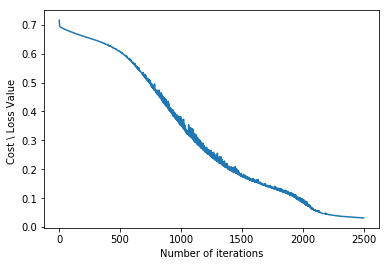

In [490]:
#data files 
training_file = 'dataset/cat_not_cat_dataset/train_catvsnotcat.h5'
test_file = 'dataset/cat_not_cat_dataset/test_catvsnotcat.h5'

## Neural net inputs]
layers_dimensions = [12288, 20, 7, 5, 1]
learning_rate = 0.0075
number_of_iterations = 2500

# load data
train_x, train_y, test_x,test_y,classes = load_data_set(training_file,test_file)

# reshape input data and normalize
training_x_flatten = train_x.reshape(train_x.shape[0],-1).T #  -1 for collapase other dimensions  # T - Transpose
training_y_flatten = train_y.reshape(train_x.shape[0],-1).T
test_x_flatten = test_x.reshape(test_x.shape[0],-1).T #  -1 for collapase other dimensions  # T - Transpose
test_y_flatten = test_y.reshape(test_x.shape[0],-1).T
train_x = training_x_flatten / 255 
test_x = test_x_flatten / 255
train_y = training_y_flatten 
test_y = test_y_flatten 

## Train a neural network model
model  = NN_model(X=train_x,
                      Y=train_y,
                      layers_dim=layers_dimensions,
                      learning_rate=learning_rate,
                      number_of_iterations=number_of_iterations)
## prediction
prediction = predict(X= test_x,parameters=model,layers_dimensions=layers_dimensions)

## test accuracy
accuracy_value = accuracy(test_y,prediction)

print("Accuracy of test set : " , accuracy_value)

In [489]:
accuracy(test_y,prediction)


0.78

#### viewing an image in matplotlib

Data set load Successful~~~
Number of samples in training data : 209


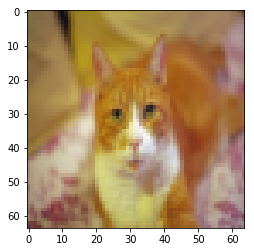

This is a  b'cat' image


In [491]:
train_x, train_y, test_x,test_y,classes = load_data_set(training_file,test_file)
index = 24
plt.imshow(train_x[index])
plt.show()
print('This is a ',str(classes[train_y[index]][:]), 'image')